## Disclaimer

We have removed outliers and split the training and test set (see `src/data-preparation` for details).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

In [2]:
input_train_path = os.path.join(
    '..',
    'dataset',
    'preprocessed',
    'df_train.csv'
)

df_train = pd.read_csv(input_train_path)
df_train.head()

input_test_path = os.path.join(
    '..',
    'dataset',
    'preprocessed',
    'df_test.csv'
)
df_test = pd.read_csv(input_test_path)

In [3]:
df_train.dtypes

startHour                     float64
startWeekday                  float64
duration                      float64
cCount                        float64
cMinPrice                     float64
cMaxPrice                     float64
cSumPrice                     float64
bCount                        float64
bMinPrice                     float64
bMaxPrice                     float64
bSumPrice                     float64
bStep                         float64
onlineStatus                    int64
availability                   object
maxVal                        float64
customerScore                 float64
accountLifetime               float64
payments                      float64
age                           float64
address                         int64
lastOrder                     float64
startHour_is_outlier            int64
startWeekday_is_outlier         int64
duration_is_outlier             int64
cCount_is_outlier               int64
cMinPrice_is_outlier            int64
cMaxPrice_is

In [4]:
## create categorical values based on startHour
def determine_time_of_day(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    condition_list = [
        ((df[column_name] >= 0) & (df[column_name] < 6)),
        ((df[column_name] >= 6) & (df[column_name] < 12)),
        ((df[column_name] >= 12) & (df[column_name] < 18)),
        ((df[column_name] >= 18) & (df[column_name] < 25)),
    ]

    choice_list = [
        "early_morning",
        "morning",
        "afternoon",
        "evening"
    ]

    df["time_of_day"] = np.select(condition_list, choice_list, default="unknown")
    return df

df_train = determine_time_of_day(df=df_train, column_name='startHour')
df_test = determine_time_of_day(df=df_test, column_name='startHour')

In [5]:
df_train[["startHour","time_of_day"]]

,startHour,time_of_day
0,18.0,evening
1,21.0,evening
2,13.0,afternoon
3,15.0,afternoon
4,17.0,afternoon
...,...,...
173011,8.0,morning
173012,15.0,afternoon
173013,18.0,evening
173014,12.0,afternoon


In [6]:
## use one hot encoder for categorical values
from sklearn.preprocessing import OneHotEncoder

selected_feature_list = ['availability','address','time_of_day','onlineStatus']
for selected_feature in selected_feature_list:
    ohe = OneHotEncoder()
    feature_array = np.array(df_train[selected_feature])
    feature_encoded = ohe.fit_transform(np.reshape(feature_array, (-1,1))).toarray()
    ## test set
    feature_array_test = np.array(df_test[selected_feature])
    feature_encoded_test = ohe.transform(np.reshape(feature_array_test, (-1,1))).toarray()

    try:
        feature_encoded = pd.DataFrame(
            data = feature_encoded, 
            columns = [selected_feature + '_' + col.str.replace(' ','_') for col in ohe.categories_[0]]
        )
        feature_encoded_test = pd.DataFrame(
            data = feature_encoded_test, 
            columns = [selected_feature + '_' + col.str.replace(' ','_') for col in ohe.categories_[0]]
        )
    except:
        print(selected_feature)
        feature_encoded = pd.DataFrame(
            data = feature_encoded, 
            columns = [selected_feature + '_' + str(col).replace(' ','_') for col in ohe.categories_[0]]
        )
        feature_encoded_test = pd.DataFrame(
            data = feature_encoded_test, 
            columns = [selected_feature + '_' + str(col).replace(' ','_') for col in ohe.categories_[0]]
        )
        
    feature_encoded.drop(
        feature_encoded.columns[-1], 
        axis = 1,
        inplace = True
    )
    feature_encoded_test.drop(
        feature_encoded_test.columns[-1], 
        axis = 1,
        inplace = True
    )

    df_train = pd.concat([df_train, feature_encoded], axis = 1)
    df_test = pd.concat([df_test, feature_encoded_test], axis = 1)
    
    ## remove redundant features - we've done one hot encoding
    df_train.drop(
        labels=selected_feature, 
        axis=1,
        inplace=True
    )
    df_test.drop(
        labels=selected_feature, 
        axis=1,
        inplace=True
    )

availability
address
time_of_day
onlineStatus


## SMOTE

In [7]:
target_class = 'order'

y_train = df_train[target_class].copy()
X_train = df_train.drop(labels=[target_class], axis=1)

In [8]:
from imblearn.over_sampling import SMOTE

RND = 722
smote = SMOTE(random_state=RND, k_neighbors=13)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [9]:
print("Training data before SMOTE: {:,.0f} records".format(X_train.shape[0]))
print("Training data after SMOTE: {:,.0f} records".format(X_train_smote.shape[0]))

Training data before SMOTE: 173,016 records
Training data after SMOTE: 238,286 records


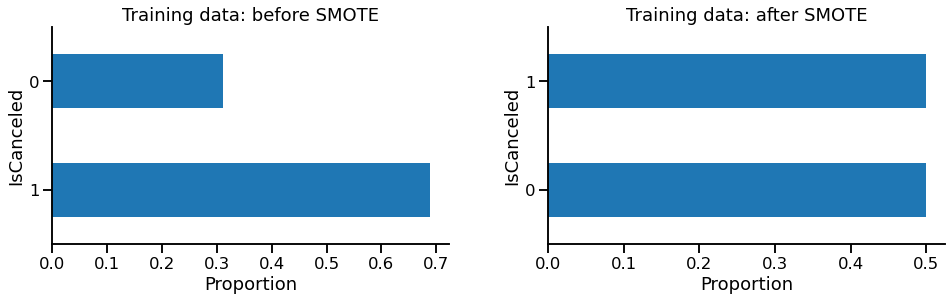

In [10]:
f, ax = plt.subplots(figsize = (16,4), ncols = 2)
plt.subplots_adjust(wspace = .25)

y_train.value_counts(True).plot.barh(ax = ax[0]);
y_train_smote.value_counts(True).plot.barh(ax = ax[1]);

ax[0].set_title("Training data: before SMOTE")
ax[0].set_ylabel("IsCanceled")
ax[0].set_xlabel("Proportion")

ax[1].set_title("Training data: after SMOTE")
ax[1].set_ylabel("IsCanceled")
ax[1].set_xlabel("Proportion")
sns.despine();

In [13]:
df_train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)
df_train_smote.shape

(238286, 53)

In [14]:
SAVE_DATA = True
FILE_NAME = 'iteration-3-train-smote.csv'

if SAVE_DATA:
    output_train_path = os.path.join(
        '..',
        'dataset',
        'research-iteration',
        'feature-engineering',
        FILE_NAME
    )
    df_train_smote.to_csv(output_train_path, index=False)
    
    output_test_path = os.path.join(
        '..',
        'dataset',
        'research-iteration',
        'feature-engineering',
        FILE_NAME.replace('train','test')
    )
    df_test.to_csv(output_test_path, index=False)